In [1]:
from importlib import reload
import config
reload(config)
import os

import torch
from torch import nn
from torch.utils.data import DataLoader

# %load_ext tensorboard

import dataset, model, trainer
import numpy as np
import util
import skimage

30:	 [id = 30.000,], [A = 1.915,], [bg = 1.414,], [x = -1.072,], [y = 3.854,], [z = 0.000,],
7:	 [id = 7.000,], [A = 1.866,], [bg = 5.111,], [x = -2.617,], [y = -4.565,], [z = 0.000,],
27:	 [id = 27.000,], [A = 1.530,], [bg = 1.747,], [x = 1.439,], [y = -2.782,], [z = 0.000,],
9:	 [id = 9.000,], [A = 1.789,], [bg = 4.472,], [x = 0.290,], [y = 4.872,], [z = 0.000,],
24:	 [id = 24.000,], [A = 1.506,], [bg = 7.310,], [x = 1.906,], [y = -1.687,], [z = 0.000,],
22:	 [id = 22.000,], [A = 1.974,], [bg = 5.045,], [x = -1.810,], [y = 2.766,], [z = 0.000,],
16:	 [id = 16.000,], [A = 1.642,], [bg = 3.245,], [x = -3.571,], [y = 1.322,], [z = 0.000,],
2:	 [id = 2.000,], [A = 1.904,], [bg = 2.965,], [x = -1.553,], [y = 1.641,], [z = 0.000,],
14:	 [id = 14.000,], [A = 1.659,], [bg = 9.235,], [x = 4.020,], [y = -3.473,], [z = 0.000,],
15:	 [id = 15.000,], [A = 1.785,], [bg = 7.000,], [x = -4.401,], [y = -1.636,], [z = 0.000,],
25:	 [id = 25.000,], [A = 1.574,], [bg = 0.470,], [x = 2.325,], [y = 0.043,

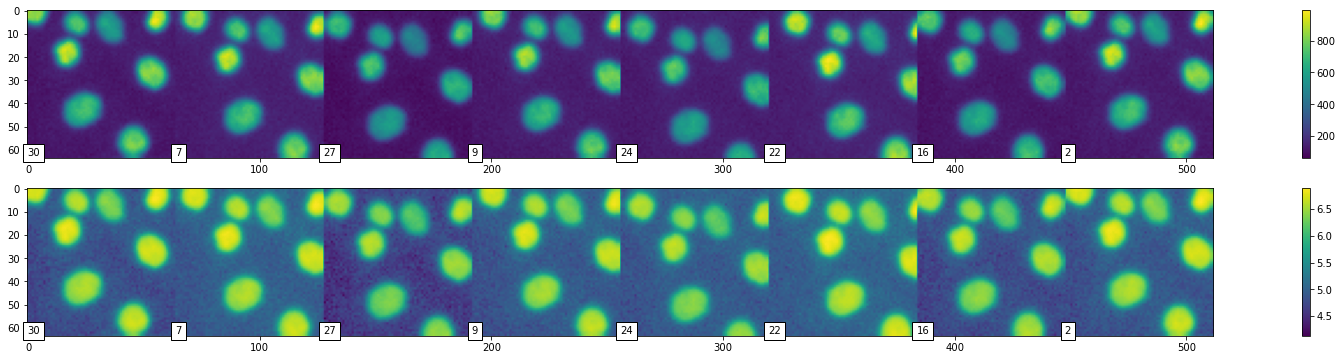

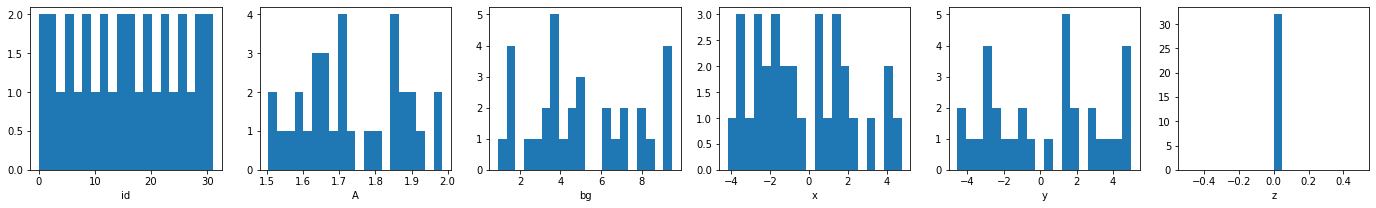

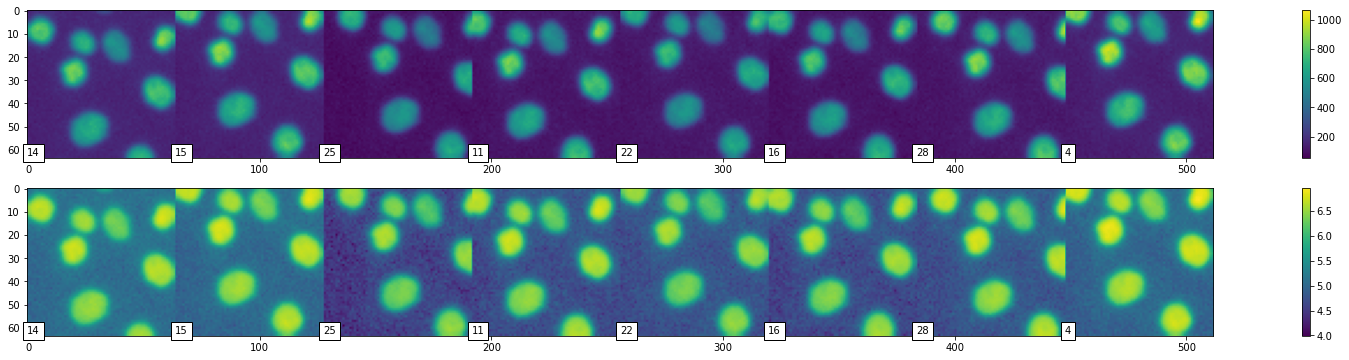

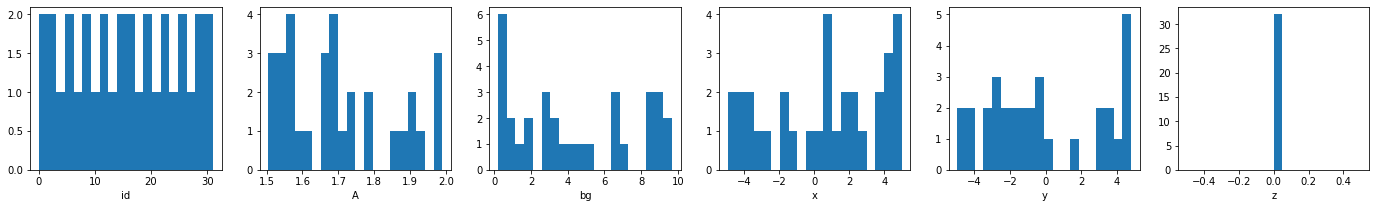

In [2]:
reload(dataset)

x = np.linspace(-1, 1, 7)
X, Y = np.meshgrid(x, x, indexing='ij')
sig = 1/3
kernel = np.exp(-(X**2/(2*sig**2) + Y**2/(2*sig**2)))
kernel /= 1
# print(kernel)

settings = {
    'data': skimage.data.human_mitosis()[20:, 20:],
    'out_size': (64,64),
    'length': 32,
    'image_params': {'A': [1.5, 2.0],
                     'bg': [0, 10],
                     'x': [-5, 5],
                     'y': [-5, 5],
                    },
    'conv_kernel':kernel,
    # 'noise_params': {},
    'augmentations': {},
    'normalize': False
}

training_data = dataset.SingleImageDataset(**settings)
dataset.inspect_images(training_data)
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)


valid_data = dataset.SingleImageDataset(**settings)
dataset.inspect_images(valid_data)
valid_dataloader = DataLoader(valid_data, batch_size=64, shuffle=True)

C:\GitHub\smlm-dl\smlm_dl\model.py:496: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if template_init is None or template_init == 'gauss':
C:\Users\kkc29\Anaconda3\envs\smlm-dl\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


CUDA not available. Defaulting to CPU
Device: cpu
Layer (type (var_name))                       Output Shape              Param #
Template2DModel                               --                        --
├─ConvImageEncoderModel (encoder)             [8, 4, 1, 1]              --
│    └─ModuleDict (encoders)                  --                        --
│    │    └─Sequential (conv_layer0)          [8, 16, 32, 32]           --
│    │    │    └─Conv2d (0)                   [8, 16, 64, 64]           160
│    │    │    └─GELU (1)                     [8, 16, 64, 64]           --
│    │    │    └─Conv2d (2)                   [8, 16, 64, 64]           2,320
│    │    │    └─GELU (3)                     [8, 16, 64, 64]           --
│    │    │    └─MaxPool2d (4)                [8, 16, 32, 32]           --
│    │    │    └─Dropout2d (5)                [8, 16, 32, 32]           --
│    │    └─Sequential (conv_layer1)          [8, 32, 16, 16]           --
│    │    │    └─Conv2d (0)              

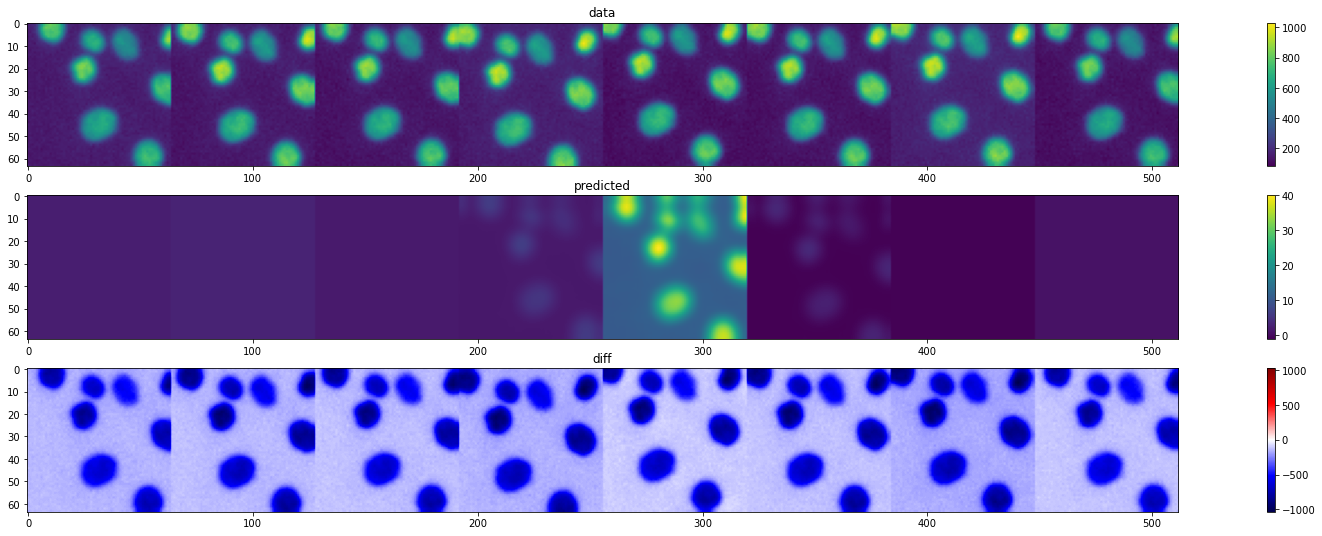

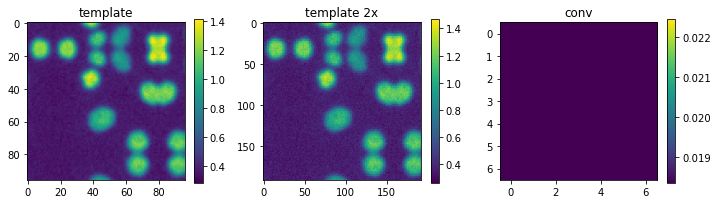

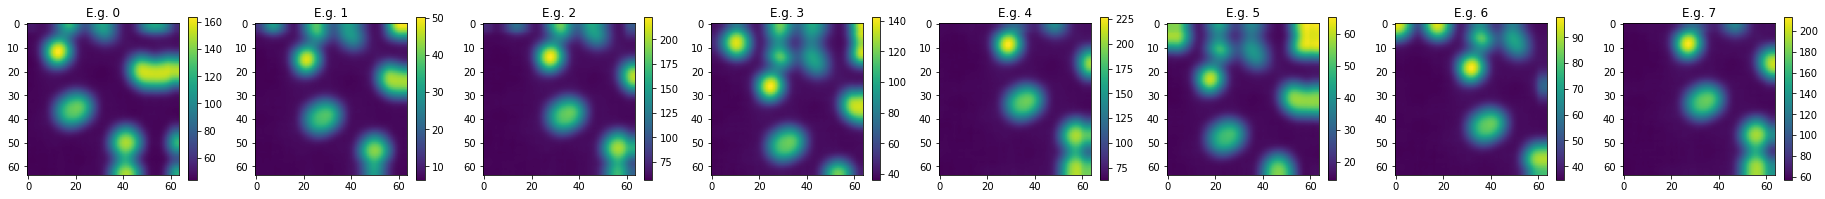

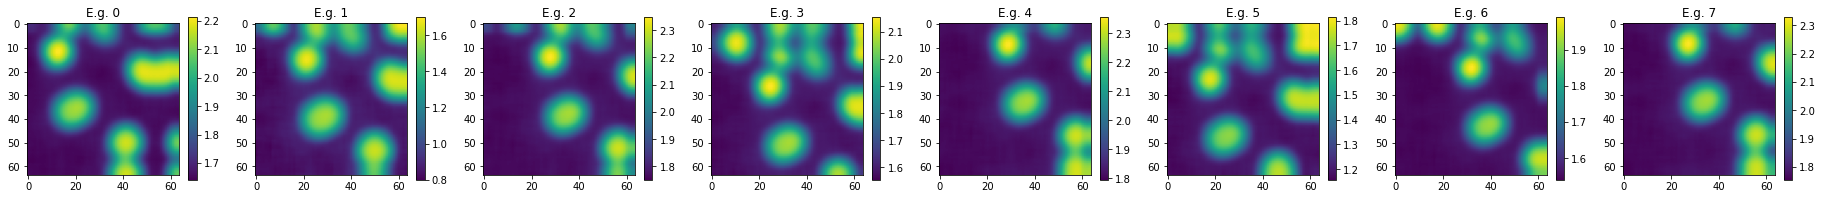

In [3]:
reload(trainer)
reload(model)
from torchinfo import summary



params_ref_override = {
            'x': model.FitParameter(nn.Hardtanh(), 0, 10, 0, True),
            'y': model.FitParameter(nn.Hardtanh(), 0, 10, 0, True),
            'A': model.FitParameter(nn.ReLU(), 0., 200, 1, True),
            'bg': model.FitParameter(nn.Tanh(), 0, 20, 0, False),
}

template = training_data[0][0].mean(0)
template -= template.min()
template /= template.max()
template -= 0.05

fitting_model = model.Template2DModel(
                                      # feedback_class=model.CropAndConcatFeedbackModel,
                                      img_size=(64,64),
                                      fit_params=['x','y','bg','A'],
                                      # max_psf_count=3,
                                      renderer_params={"template_init":template, "template_padding":(16,16),
                                                      "conv":7
                                                      },
                                      encoder_params={"depth":3, "first_layer_out_channels":16},
                                     params_ref_override=params_ref_override)

# optimizer = torch.optim.AdamW(fitting_model.parameters(), lr=2e-4)

optimizer = torch.optim.AdamW([{"params":fitting_model.encoder.parameters(), "lr":5e-4},
                                        {"params":fitting_model.renderer.parameters(), "lr":5e-4}],
                                        lr=1e-4)


training = trainer.FittingTrainer(fitting_model, train_dataloader, valid_dataloader, optimizer=optimizer)


# training.train_and_validate(2,)
print(summary(fitting_model, input_size=(8, 1, 64, 64), row_settings=["var_names"], depth=4))
model.check_model(fitting_model, train_dataloader)

Saved to : F:\Pytorch\runs\2021-12-21_19-05-59_MW1E008F61_conv_test_a\model.ptm


  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

C:\Users\kkc29\Anaconda3\envs\smlm-dl\lib\site-packages\torch\autograd\__init__.py:154: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ..\aten\src\ATen\native\Copy.cpp:244.)
  Variable._execution_engine.run_backward(


Saved to : F:\Pytorch\runs\2021-12-21_19-05-59_MW1E008F61_conv_test_a\checkpoint.ptc
model_state_dict: odict_keys(['renderer.scale_factor', 'renderer.template.0.parameter', 'renderer.conv.0.parameter', 'encoder.encoders.conv_layer0.0.weight', 'encoder.encoders.conv_layer0.0.bias', 'encoder.encoders.conv_layer0.2.weight', 'encoder.encoders.conv_layer0.2.bias', 'encoder.encoders.conv_layer1.0.weight', 'encoder.encoders.conv_layer1.0.bias', 'encoder.encoders.conv_layer1.2.weight', 'encoder.encoders.conv_layer1.2.bias', 'encoder.encoders.conv_layer2.0.weight', 'encoder.encoders.conv_layer2.0.bias', 'encoder.encoders.conv_layer2.2.weight', 'encoder.encoders.conv_layer2.2.bias', 'encoder.neck.conv_layer_0.0.weight', 'encoder.neck.conv_layer_0.0.bias', 'encoder.neck.conv_layer_0.1.weight', 'encoder.neck.conv_layer_0.1.bias', 'encoder.neck.conv_layer_0.3.weight', 'encoder.neck.conv_layer_0.3.bias', 'encoder.neck.conv_layer_0.4.weight', 'encoder.neck.conv_layer_0.4.bias', 'encoder.neck.conv_lay

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Saved to : F:\Pytorch\runs\2021-12-21_19-06-11_MW1E008F61_conv_test_b\checkpoint.ptc
model_state_dict: odict_keys(['renderer.scale_factor', 'renderer.template.0.parameter', 'renderer.conv.0.parameter', 'encoder.encoders.conv_layer0.0.weight', 'encoder.encoders.conv_layer0.0.bias', 'encoder.encoders.conv_layer0.2.weight', 'encoder.encoders.conv_layer0.2.bias', 'encoder.encoders.conv_layer1.0.weight', 'encoder.encoders.conv_layer1.0.bias', 'encoder.encoders.conv_layer1.2.weight', 'encoder.encoders.conv_layer1.2.bias', 'encoder.encoders.conv_layer2.0.weight', 'encoder.encoders.conv_layer2.0.bias', 'encoder.encoders.conv_layer2.2.weight', 'encoder.encoders.conv_layer2.2.bias', 'encoder.neck.conv_layer_0.0.weight', 'encoder.neck.conv_layer_0.0.bias', 'encoder.neck.conv_layer_0.1.weight', 'encoder.neck.conv_layer_0.1.bias', 'encoder.neck.conv_layer_0.3.weight', 'encoder.neck.conv_layer_0.3.bias', 'encoder.neck.conv_layer_0.4.weight', 'encoder.neck.conv_layer_0.4.bias', 'encoder.neck.conv_lay

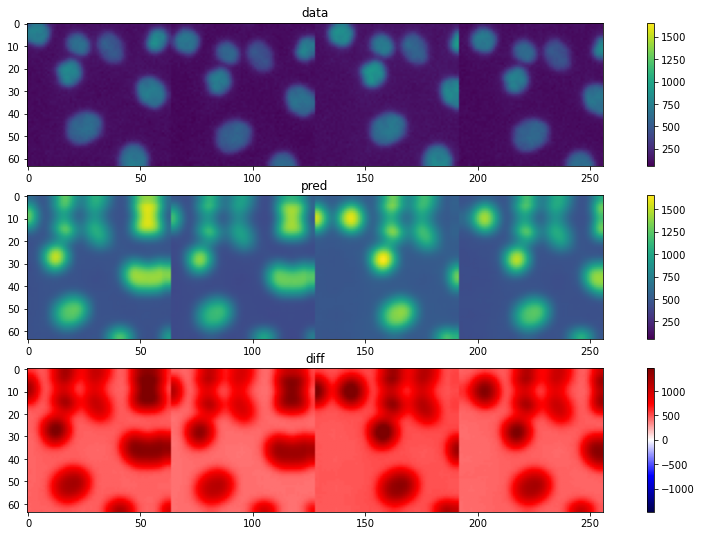

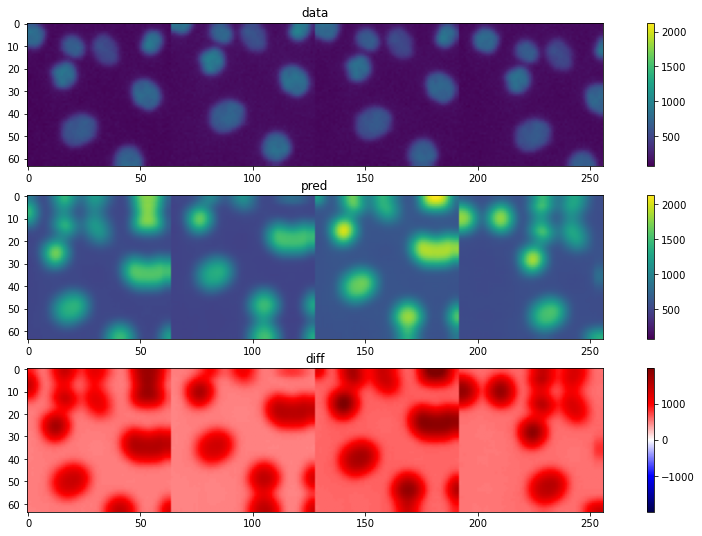

In [4]:
reload(trainer)
training.train_and_validate(10, training_interval=1, validate_interval=10, label="conv_test_a", tb_log_limit_images=4)

training.optimizer = torch.optim.AdamW([{"params":fitting_model.encoder.parameters(), "lr":5e-5},
                                        {"params":fitting_model.renderer.parameters(), "lr":5e-5}],
                                        lr=1e-4)

# for i in fitting_model.modules():
#     if isinstance(i, torch.nn.modules.dropout.Dropout2d):
#         # print(type(i))
#         # i.train(False)
#         # print(i.p)
#         i.p = 0.01

training.train_and_validate(10, training_interval=1, validate_interval=10, label="conv_test_b", tb_log_limit_images=4)

In [5]:
# reload(trainer)

# training.optimizer = torch.optim.AdamW([{"params":fitting_model.encoder.parameters(), "lr":5e-5},
#                                         {"params":fitting_model.renderer.parameters(), "lr":5e-5}],
#                                         lr=1e-4)

# for i in fitting_model.modules():
#     if isinstance(i, torch.nn.modules.dropout.Dropout2d):
#         # print(type(i))
#         # i.train(False)
#         # print(i.p)
#         i.p = 0.05

# training.train_and_validate(1000000, training_interval=1, validate_interval=10, label="conv_c", tb_log_limit_images=4)

In [6]:
# training.optimizer = torch.optim.AdamW([{"params":fitting_model.encoder.parameters(), "lr":1e-4},
#                                         {"params":fitting_model.renderer.parameters(), "lr":1e-4}],
#                                         lr=1e-4)

# for i in fitting_model.modules():
#     if isinstance(i, torch.nn.modules.dropout.Dropout2d):
#         # print(type(i))
#         # i.train(False)
#         # print(i.p)
#         i.p = 0.01

# training.train_and_validate(1000000, training_interval=1, validate_interval=10, label="conv_d", tb_log_limit_images=4)

In [7]:
# training.train_and_validate(1000000, training_interval=1, validate_interval=10, label="conv_a", tb_log_limit_images=4)

In [8]:
# training.optimizer = torch.optim.AdamW([{"params":fitting_model.encoder.parameters(), "lr":2e-4},
#                                         {"params":fitting_model.renderer.parameters(), "lr":2e-3}],
#                                         lr=1e-4)
# training.train_and_validate(1000000, training_interval=1, validate_interval=10, label="conv_b", tb_log_limit_images=4)

In [9]:
# # training.validate()
# mapped_params = training.model.mapped_params
# # print(mapped_params['id'])
# print(training_data.params['id'])

# fit_params=['x','y','bg','A']

# init_weights = list()
# for p in fit_params:
#     init_weights.append(training_data.params[p].flatten())
#     print(init_weights[-1].shape)
# init_weights = np.stack(init_weights)
# print(init_weights.shape)

In [10]:
# fitting_model = model.Template2DModel(
#                                       # feedback_class=model.CropAndConcatFeedbackModel,
#                                         encoder_class = model.IdEncoderModel,
#                                       img_size=(64,64),
#                                       fit_params=fit_params,
#                                       # max_psf_count=3,
#                                       renderer_params={"template_init":template, "template_padding":(16,16),
#                                                       "conv":7},
#                                       encoder_params={"num_img":len(training_data), "init_weights":init_weights},
#                                      params_ref_override=params_ref_override)

# optimizer = torch.optim.AdamW(fitting_model.parameters(), lr=1e-2)


# training = trainer.FittingTrainer(fitting_model, train_dataloader, valid_dataloader, optimizer=optimizer)


# # training.train_and_validate(2,)
# print(summary(fitting_model, input_size=(len(training_data),), row_settings=["var_names"], depth=4))
# model.check_model(fitting_model, train_dataloader)

In [11]:
# training.train_and_validate(1000000, training_interval=1, validate_interval=10, label="conv_idEncd_a", tb_log_limit_images=4)

In [12]:
# training.optimizer = torch.optim.AdamW([{"params":fitting_model.encoder.parameters(), "lr":1e-4},
#                                         {"params":fitting_model.renderer.parameters(), "lr":1e-3}],
#                                         lr=1e-4)

# training.train_and_validate(1000000, training_interval=10, validate_interval=100, label="noFB_d4_in32_a", tb_log_limit_images=4)

In [13]:
# training.optimizer = torch.optim.AdamW([{"params":fitting_model.encoder.parameters(), "lr":1e-4},
#                                         {"params":fitting_model.renderer.parameters(), "lr":1e-3}],
#                                         lr=1e-4)

# training.train_and_validate(1000000, training_interval=10, validate_interval=100, label="noFB_d3_in16_c", tb_log_limit_images=4)

In [14]:
# reload(model)
# model.check_model(fitting_model, train_dataloader)

In [15]:
# reload(model)
# reload(trainer)
# training = trainer.FittingTrainer.from_model_file(r"F:\Pytorch\runs\2021-12-08_01-56-04_MW1E008F61_noFB_d4_in32\model.ptm")
# training.train_data_loader = train_dataloader
# print(training.model.fit_params)
# print(training.model.params_ref)
# # model.check_model(training.model)

In [16]:
# # print(training_data.params)

# x, y = next(iter(train_dataloader))
# # print(x.shape)
# # print(y)
# # training.model.call

# pred = training.model.call_auto(x, y)
# # print(pred)

# from matplotlib import pyplot as plt

# plt.figure()
# plt.scatter(training_data.params['x'], y['x'])
# plt.scatter(training_data.params['y'], y['y'])
